<a href="https://colab.research.google.com/github/airesx2/Internship-2025/blob/main/Password_Buster_(cudaq).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cudaq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 MB 5.6 MB/s eta 0:00:00
  Created wheel for cudaq: filename=cudaq-0.11.0-py3-none-any.whl size=6897 sha256=116572e3c137924337f4fc36fac90804306d6bb149ec1a23937407094efa3722
  Stored in directory: /root/.cache/pip/wheels/ad/0f/19/60352710d764963c7c1cb5d5f1ab78dc76e1b542899b33c35a
Successfully built cudaq


Draft 1: Hard coded brute force that only accepts 2 qubits at a time

In [ ]:
import cudaq

In [ ]:
#Password Brute Force with grover's algorithm
#Starting with 2 qubits (hardcoded)

#Had to move this segment out b/c cudaq didn't support >>
def target_to_bits(target, n):
    #>> shifts bits of a number to the right
    return [(target >> (n - 1 - i)) & 1 for i in range(n)]


@cudaq.kernel #remember the decorator!
def search(bit_pattern: list[int]):

  #Step 1: Create state 0 qubits
  n = len(bit_pattern)
  qubits = cudaq.qvector(n) #initialize n qubits

  #Step 2: Superposition
  for q in qubits:
    h(q) #apply H gate to all qubits

  #looping for better success probability
  for i in range(n*2):

    #Step 3: Oracle
    for i in range(n): #apply x gates on qubits that should be 0 in the target state
      if bit_pattern[i] == 0:
        x(qubits[i])

    cz(qubits[0], qubits[1]) #flip target state (qubit[1]) only if control qubit (qubit[0]) is 1

    for i in range(n): #apply x gates on qubits that should be 0 in the target state
      if bit_pattern[i] == 0:
        x(qubits[i])

    #Step 4: Diffusion
    #reflects the state through origin
    for q in qubits: #puts qubits in "mirror state"
      h(q) #back to superposition
      x(q) #flip qubit

    #reflection step
    cz(qubits[0], qubits[1]) #state vector reflected around the mean amplitude

    for q in qubits: #undo
      x(q)
      h(q)

  #Step 5: Measure
  for q in qubits:
        mz(q)

#Step 6: Run & Sample

#inputs
n = 2 #number of qubits
target = 3
bit_pattern = target_to_bits(target, n)

#run
result = cudaq.sample(search, bit_pattern) #run sample
target_bin = format(target, f'0{n}b') #convert target to binary
result_dict = {key: result.count(key) for key in result} #loops over bitstrings, gets total count
success_count = result.count(target_bin) #count no. correct state, only accepts binary
total_shots = sum(result_dict.values()) #total number of shots (default is 1000)
success_rate = (success_count / total_shots) * 100 #calculate success rate as %
print(f"Result for target = |{target:02b}⟩:")
print(result)
print(f"Success rate: {success_rate:.2f}%")



Result for target = |11⟩:
{ 11:1000 }

Success rate: 100.00%


Draft 2: Brute force that accepts ints, letters, and special chars with a limit of 16 qubits at a time

In [2]:
#Added functional user input
#limit 16 bits  (16 bit ints + two letters + special characters )
import cudaq
import math
import time

def target_to_bits(target, n):
    #>> shifts bits of a number to the right
    return [(target >> (n - 1 - i)) & 1 for i in range(n)]


@cudaq.kernel #remember the decorator!
def search(bit_pattern: list[int], iterations: int):

  #Step 1: Create state 0 qubits
  n = len(bit_pattern)
  qubits = cudaq.qvector(n) #initialize n qubits

  #Step 2: Superposition
  for q in qubits:
    h(q) #apply H gate to all qubits

  #looping for better success probability
  for i in range(iterations):

    #Step 3: Oracle
    for i in range(n): #apply x gates on qubits that should be 0 in the target state
      if bit_pattern[i] == 0:
        x(qubits[i])

    #crashes if 1 or 2, z.ctrl only works for n>2
    #only way is to hard code this because cudaq has a bunch of compiler restrictions
    #i've tried lists, predefined, internally defined, spliting... everything
    if n == 1:
        z(qubits[0])
    elif n == 2:
        cz(qubits[0], qubits[1])
    elif n == 3:
        z.ctrl([qubits[0], qubits[1]], qubits[2])
    elif n == 4:
        z.ctrl([qubits[0], qubits[1], qubits[2]], qubits[3])
    elif n == 5:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3]], qubits[4])
    elif n == 6:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4]], qubits[5])
    elif n == 7:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5]], qubits[6])
    elif n == 8:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6]], qubits[7])
    elif n == 9:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7]], qubits[8])
    elif n == 10:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8]], qubits[9])
    elif n == 11:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9]], qubits[10])
    elif n == 12:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10]], qubits[11])
    elif n == 13:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11]], qubits[12])
    elif n == 14:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12]], qubits[13])
    elif n == 15:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13]], qubits[14])
    elif n == 16:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13], qubits[14]], qubits[15])
    elif n == 17:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13], qubits[14], qubits[15]], qubits[16])
    else:
      return
    for i in range(n): #apply x gates on qubits that should be 0 in the target state
      if bit_pattern[i] == 0:
        x(qubits[i])

    #Step 4: Diffusion
    #reflects the state through origin
    for q in qubits: #puts qubits in "mirror state"
      h(q) #back to superposition
      x(q) #flip qubit

    #reflection step
    if n == 1:
      z(qubits[0])
    elif n == 2:
        cz(qubits[0], qubits[1])
    elif n == 3:
        z.ctrl([qubits[0], qubits[1]], qubits[2])
    elif n == 4:
        z.ctrl([qubits[0], qubits[1], qubits[2]], qubits[3])
    elif n == 5:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3]], qubits[4])
    elif n == 6:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4]], qubits[5])
    elif n == 7:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5]], qubits[6])
    elif n == 8:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6]], qubits[7])
    elif n == 9:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7]], qubits[8])
    elif n == 10:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8]], qubits[9])
    elif n == 11:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9]], qubits[10])
    elif n == 12:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10]], qubits[11])
    elif n == 13:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11]], qubits[12])
    elif n == 14:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12]], qubits[13])
    elif n == 15:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13]], qubits[14])
    elif n == 16:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13], qubits[14]], qubits[15])
    elif n == 17:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13], qubits[14], qubits[15]], qubits[16])
    else:
      return

    for q in qubits: #undo
      x(q)
      h(q)

  #Step 5: Measure
  for q in qubits:
        mz(q)

#Step 6: Run & Sample

#inputs/vars
usr_input = input("Enter a password... ").strip() #strip removes spaces before and after

if usr_input.isdigit():
  target = int(usr_input)
  is_word = False
else:
  #ord gives you ASCII int for each char
  #'o8b' turns int 8 bit binary string
  #''.join combines all the binary strings together
  bits = ''.join(format(ord(c), '08b') for c in usr_input)  #convert letters to binary
  target = int(bits, 2) #converts binary string to int
  is_word = True

n = target.bit_length()  #num of bits for the target
bit_pattern = target_to_bits(target, n)
#optimal iterations = pi/4 * root(N)
iterations = round((math.pi / 4) * math.sqrt(2 ** n))

#run
start_time = time.time()
result = cudaq.sample(search, bit_pattern, iterations) #run sample
end_time = time.time()
print(f"Result for target = |{target:02b}⟩:")
print(result)

#success rate
target_bin = format(target, f'0{n}b')  #int to binary, pads with 0s to match len n
success_count = result.count(target_bin)  #no. times target counted
total_shots = sum([result.count(key) for key in result])  #loop for total count
success_rate = (success_count / total_shots) * 100  #calc as percentage

#decode password
if is_word:
    #find the most frequent correct result
    #result.items() gives list of (bitstring, count) pairs
    #max(..., ley=lambda item: item[1]) gets most frequent bitstring (grover's guess)
    #[0] gets only the bitstring from item pair
    result_str = max(result.items(), key=lambda item: item[1])[0]
    #result_str[i:i+8] slides 8 bits at a time
    #int(..., 2) turns each 8 bit slice into an ASCII num
    #chr turns ASCII num to char
    # ro i in range every character
    chars = [chr(int(result_str[i:i+8], 2)) for i in range(0, len(result_str), 8)]
    decoded_word = ''.join(chars) #join chars together into word
    print(f"\nDecoded password... {decoded_word}")
else:
    print(f"\nDecoded password... {int(target_bin, 2)}")

print(f"SUCCESS RATE: {success_rate:.2f}%")
print(f"RUN TIME: {end_time - start_time:.2f} s")



Enter a password... 8
Result for target = |1000⟩:
{ 0000:2 0001:2 0010:3 0011:1 0100:1 0111:4 1000:968 1001:4 1010:4 1011:5 1101:2 1110:3 1111:1 }


Decoded password... 8
SUCCESS RATE: 96.80%
RUN TIME: 0.28 s


===BEST===
Draft 3: Brute force with added Hashing, Salting, and Sample size visual (compare with non hashing program)

Enter a password... u
🧂Generated Salt:  ab4c7e63
Result for target = |01110100⟩:
{ 00011101:1 01010111:1 01110100:995 11001010:1 11011011:1 11110100:1 }



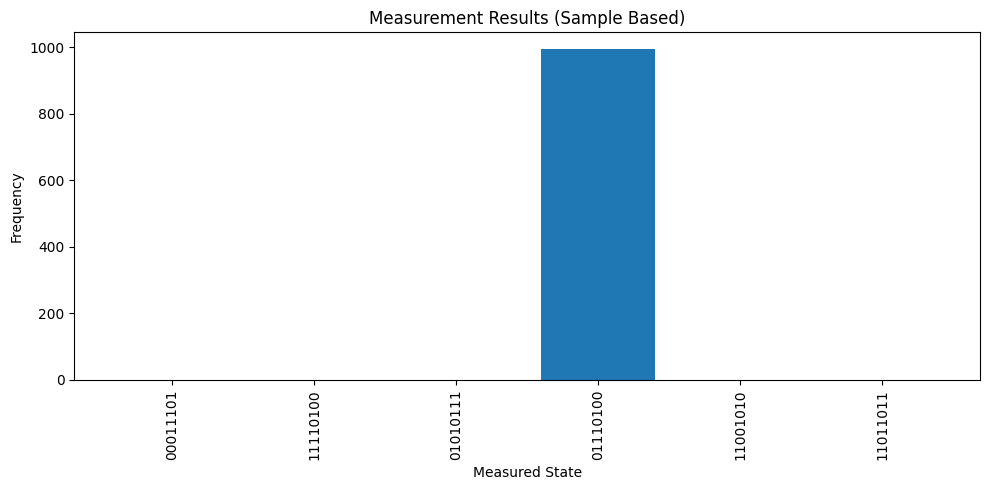

Hash value: 74bd97833ecb0bdc82d178953803b33a623e8bb2c64cd93e5583df43e54cd3f6
Binary passwd: 01110100
Hex passwd: 74


SUCCESS RATE: 99.50%
RUN TIME: 0.17 s


In [1]:
#With Hashing!! + Salt!!
#Add sample size visual
#Note that with hashing + salt, the success rate is lower than w/o hashing + salt (compare with previous draft)
#Also note that salt makes every password unique even when same input is given
import cudaq
import math
import time
import hashlib #for hash
import secrets #for salt
import matplotlib.pyplot as plt

@cudaq.kernel #remember the decorator!
def search(bit_pattern: list[int], iterations: int):

  #Step 1: Create state 0 qubits
  n = len(bit_pattern)
  qubits = cudaq.qvector(n) #initialize n qubits

  #Step 2: Superposition
  for q in qubits:
    h(q) #apply H gate to all qubits

  #looping for better success probability
  for i in range(iterations):

    #Step 3: Oracle
    for i in range(n): #apply x gates on qubits that should be 0 in the target state
      if bit_pattern[i] == 0:
        x(qubits[i])

    #crashes if 1 or 2, z.ctrl only works for n>2
    #only way is to hard code this because cudaq has a bunch of compiler restrictions
    #i've tried lists, predefined, internally defined, spliting... everything
    if n == 1:
        z(qubits[0])
    elif n == 2:
        z.ctrl(qubits[0], qubits[1])
    elif n <=17:
        ctrls = qubits.front(qubits.size() - 1)
        target = qubits.back()
        z.ctrl(ctrls, target)
    else:
      return
    for i in range(n): #apply x gates on qubits that should be 0 in the target state
      if bit_pattern[i] == 0:
        x(qubits[i])

    #Step 4: Diffusion
    #reflects the state through origin
    for q in qubits: #puts qubits in "mirror state"
      h(q) #back to superposition
      x(q) #flip qubit

    #reflection step
    if n == 1:
        z(qubits[0])
    elif n == 2:
        z.ctrl(qubits[0], qubits[1])
    elif n <=17:
        ctrls = qubits.front(qubits.size() - 1)
        target = qubits.back()
        z.ctrl(ctrls, target)
    else:
      return

    for q in qubits: #undo
      x(q)
      h(q)

  #Step 5: Measure
  for q in qubits:
        mz(q)

#Step 6: Run & Sample

#inputs/vars
usr_input = input("Enter a password... ").strip() #strip removes spaces before and after

#compute hash + salt
salt = secrets.token_hex(4) #4 bytes random salt
print(f"🧂Generated Salt:  {salt}")
salted_input = usr_input + salt #added salt!
hashed = hashlib.sha256(salted_input.encode()).hexdigest() #gets hexstring
#bin converts to binary string
#[2:] strips 0b that is added infront of binary strings
#zfills the string so that its exactly 256 bits length
hashed_bin = bin(int(hashed, 16))[2:].zfill(256) #converts hex to int to binary (256 bit)
hashed_bin = hashed_bin[:8] #truncate to 8 bits

#the bit_pattern is used in the oracle find the target, it is a list of bits that correspond with the "target" state
bit_pattern = [int(b) for b in hashed_bin]
n = len(hashed_bin)  #num of bits for the target
#optimal iterations = pi/4 * root(N)
iterations = round((math.pi / 4) * math.sqrt(2 ** n))

#run
start_time = time.time()
result = cudaq.sample(search, bit_pattern, iterations) #run sample
end_time = time.time()
print(f"Result for target = |{hashed_bin}⟩:")
print(result)

#amplitude visualize
if result is None:
    print("ERROR: cudaq.sample() returned `None`")
else:
    labels = []
    count = []
    for bitstring, freq in result.items():
      labels.append(bitstring)
      count.append(freq)

    plt.figure(figsize =(10,5))
    plt.bar(labels, count)
    plt.xlabel("Measured State")
    plt.ylabel("Frequency")
    plt.title("Measurement Results (Sample Based)")
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()

#success rate
success_count = result.count(hashed_bin)  #no. times target counted
total_shots = sum([result.count(key) for key in result])  #loop for total count
success_rate = (success_count / total_shots) * 100  #calc as percentage

#print password (remember that program is guessing the hash not the actual password, hash function is IRREVERSIBLE :D)
print(f"Hash value: {hashed}")
result_str = max(result.items(), key=lambda item: item[1])[0] #converts int to binary
result_hex = hex(int(result_str, 2))[2:] #converts binary to hex
print(f"Binary passwd: {result_str}")
print(f"Hex passwd: {result_hex}")
print("\n")
print(f"SUCCESS RATE: {success_rate:.2f}%")
print(f"RUN TIME: {end_time - start_time:.2f} s")



Draft 3: Added Amplitude Visualizer to brute force

In [ ]:
#With Amplitude Visuals
#Warning: due to poor resources, the graph doesn't show up in a reasonable time
import cudaq
import math
import time
import hashlib
import secrets
import matplotlib.pyplot as plt #for visual

@cudaq.kernel #remember the decorator!
def search(bit_pattern: list[int], iterations: int):

  #Step 1: Create state 0 qubits
  n = len(bit_pattern)
  qubits = cudaq.qvector(n) #initialize n qubits

  #Step 2: Superposition
  for q in qubits:
    h(q) #apply H gate to all qubits

  #looping for better success probability
  for i in range(iterations):

    #Step 3: Oracle
    for i in range(n): #apply x gates on qubits that should be 0 in the target state
      if bit_pattern[i] == 0:
        x(qubits[i])

    #crashes if 1 or 2, z.ctrl only works for n>2
    #only way is to hard code this because cudaq has a bunch of compiler restrictions
    #i've tried lists, predefined, internally defined, spliting... everything
    if n == 1:
        z(qubits[0])
    elif n == 2:
        z.ctrl(qubits[0], qubits[1])
    elif n == 3:
        z.ctrl([qubits[0], qubits[1]], qubits[2])
    elif n == 4:
        z.ctrl([qubits[0], qubits[1], qubits[2]], qubits[3])
    elif n == 5:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3]], qubits[4])
    elif n == 6:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4]], qubits[5])
    elif n == 7:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5]], qubits[6])
    elif n == 8:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6]], qubits[7])
    elif n == 9:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7]], qubits[8])
    elif n == 10:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8]], qubits[9])
    elif n == 11:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9]], qubits[10])
    elif n == 12:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10]], qubits[11])
    elif n == 13:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11]], qubits[12])
    elif n == 14:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12]], qubits[13])
    elif n == 15:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13]], qubits[14])
    elif n == 16:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13], qubits[14]], qubits[15])
    elif n == 17:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13], qubits[14], qubits[15]], qubits[16])
    else:
      return
    for i in range(n): #apply x gates on qubits that should be 0 in the target state
      if bit_pattern[i] == 0:
        x(qubits[i])

    #Step 4: Diffusion
    #reflects the state through origin
    for q in qubits: #puts qubits in "mirror state"
      h(q) #back to superposition
      x(q) #flip qubit

    #reflection step
    if n == 1:
      z(qubits[0])
    elif n == 2:
        cz(qubits[0], qubits[1])
    elif n == 3:
        z.ctrl([qubits[0], qubits[1]], qubits[2])
    elif n == 4:
        z.ctrl([qubits[0], qubits[1], qubits[2]], qubits[3])
    elif n == 5:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3]], qubits[4])
    elif n == 6:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4]], qubits[5])
    elif n == 7:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5]], qubits[6])
    elif n == 8:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6]], qubits[7])
    elif n == 9:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7]], qubits[8])
    elif n == 10:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8]], qubits[9])
    elif n == 11:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9]], qubits[10])
    elif n == 12:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10]], qubits[11])
    elif n == 13:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11]], qubits[12])
    elif n == 14:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12]], qubits[13])
    elif n == 15:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13]], qubits[14])
    elif n == 16:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13], qubits[14]], qubits[15])
    elif n == 17:
        z.ctrl([qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], qubits[5], qubits[6], qubits[7], qubits[8], qubits[9], qubits[10], qubits[11], qubits[12], qubits[13], qubits[14], qubits[15]], qubits[16])
    else:
      return

    for q in qubits: #undo
      x(q)
      h(q)

  #Step 5: Measure
  for q in qubits:
        mz(q)

#Step 6: Run & Sample

#inputs/vars
usr_input = input("Enter a password... ").strip() #strip removes spaces before and after

#compute hash + salt
salt = secrets.token_hex(4) #4 bytes random salt
print(f"Generated Salt:  {salt}")
salted_input = usr_input + salt #added salt!
hashed = hashlib.sha256(salted_input.encode()).hexdigest() #gets hexstring
#bin converts to binary string
#[2:] strips 0b that is added infront of binary strings
#zfills the string so that its exactly 256 bits length
hashed_bin = bin(int(hashed, 16))[2:].zfill(256) #converts hex to int to binary (256 bit)
hashed_bin = hashed_bin[:8] #truncate to 8 bits

#the bit_pattern is used in the oracle find the target, it is a list of bits that correspond with the "target" state
bit_pattern = [int(b) for b in hashed_bin]
n = len(hashed_bin)  #num of bits for the target
#optimal iterations = pi/4 * root(N)
iterations = round((math.pi / 4) * math.sqrt(2 ** n))

#run
start_time = time.time()
result = cudaq.sample(search, bit_pattern, iterations) #run sample
end_time = time.time()
print(f"Result for target = |{hashed_bin}⟩:")
print(result)

#amplitude visualize
amps = cudaq.get_state(search, bit_pattern, iterations) #get amps
probabilities = [abs(amp)**2 for amp in amps] #convert to probabilities
bitstrings = [format(i, f'0{n}b') for i in range(len(probabilities))] #generate corresponding bitstrings

plt.figure(figsize =(10,5))
plt.bar(bitstrings, probabilities)
plt.xlabel("Basis State")
plt.ylabel("Probability")
plt.title("Grover's Algorithm Amplitude Visualizer")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

#success rate
success_count = result.count(hashed_bin)  #no. times target counted
total_shots = sum([result.count(key) for key in result])  #loop for total count
success_rate = (success_count / total_shots) * 100  #calc as percentage

#print password (remember that program is guessing the hash not the actual password, hash function is IRREVERSIBLE :D)
print(f"Hash value: {hashed}")
result_str = max(result.items(), key=lambda item: item[1])[0] #converts int to binary
result_hex = hex(int(result_str, 2))[2:] #converts binary to hex
print(f"Binary passwd: {result_str}")
print(f"Hex passwd: {result_hex}")
print("\n")
print(f"SUCCESS RATE: {success_rate:.2f}%")
print(f"RUN TIME: {end_time - start_time:.2f} s")

